<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.4
# *PCA Lab*

**In this lab, we will:**
- Explore how PCA is related to correlation.
- Use PCA to perform dimensionality reduction.

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [18]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [19]:
breast_cancer_csv = '../../data/breast-cancer-wisconsin-data.csv'

In [20]:
df = pd.read_csv(breast_cancer_csv, index_col='id')

In [21]:
df.drop(labels='Unnamed: 32', axis=1, inplace=True)

### 2. EDA 

Explore dataset. Clean data. Find correlation. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

In [6]:
df.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

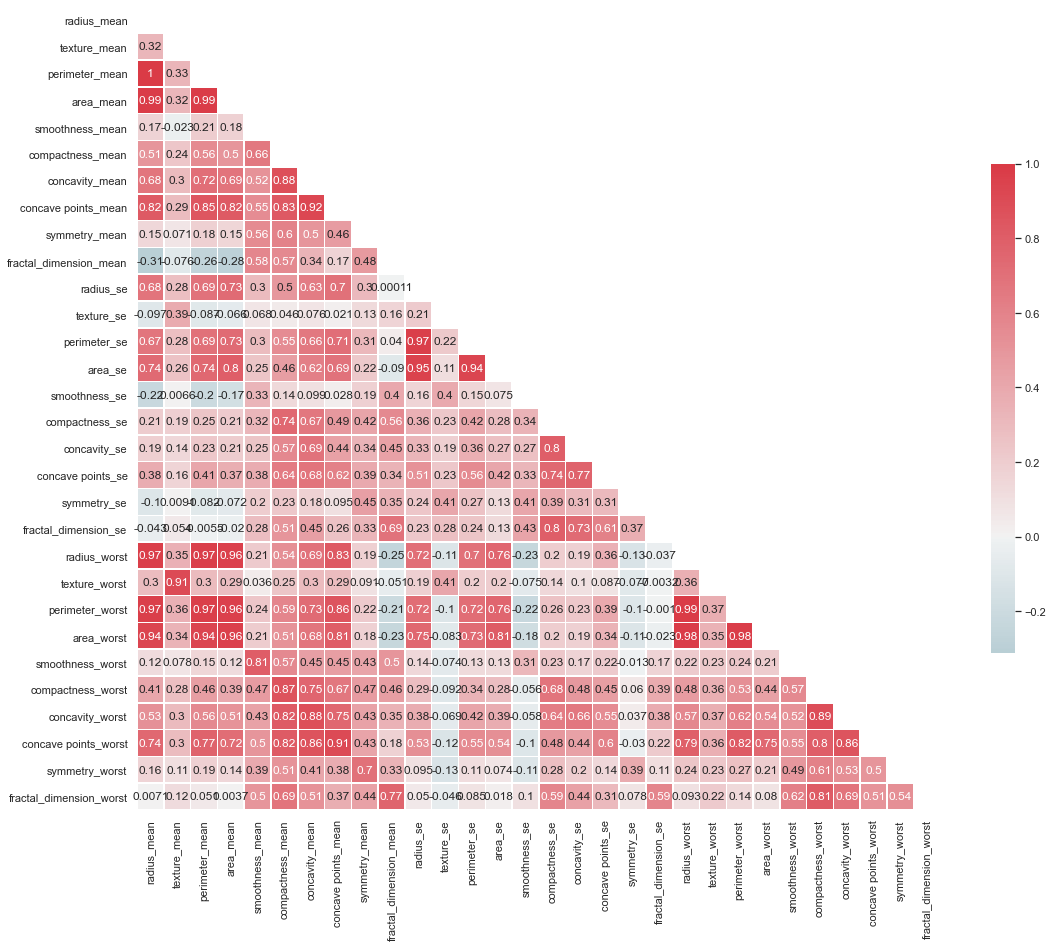

In [7]:
# Copied code from seaborn examples
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show();

<AxesSubplot:>

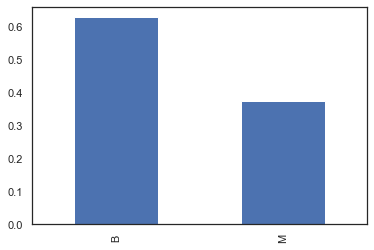

In [8]:
# ANSWER
df['diagnosis'].value_counts(normalize=True).plot(kind='bar')

In [9]:
df['diagnosis'].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

### 3. Subset & Normalize

Subset the data to only include all columns except diagnosis. We will be comparing the principal components to age specifically, so we are leaving age out.

In [10]:
from sklearn.preprocessing import StandardScaler

In [22]:
features = df.columns

In [25]:
# ANSWER
y = df['diagnosis']

In [24]:
# ANSWER
feature_columns = [c for c in df.columns if c !='diagnosis']
X = df[feature_columns]

In [26]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

### Calculate correlation matrix

We will be using the correlation matrix to calculate the eigenvectors and eigenvalues.

In [35]:
# ANSWER
corr_mat = np.corrcoef(Xs)
corr_mat 

array([[ 1.        ,  0.21183069,  0.51598519, ..., -0.45320018,
         0.36273886, -0.43760388],
       [ 0.21183069,  1.        ,  0.70777373, ...,  0.38505444,
         0.12625018, -0.35562835],
       [ 0.51598519,  0.70777373,  1.        , ...,  0.24375827,
         0.45235829, -0.56906454],
       ...,
       [-0.45320018,  0.38505444,  0.24375827, ...,  1.        ,
         0.29295393,  0.12252751],
       [ 0.36273886,  0.12625018,  0.45235829, ...,  0.29295393,
         1.        , -0.26754122],
       [-0.43760388, -0.35562835, -0.56906454, ...,  0.12252751,
        -0.26754122,  1.        ]])

### 4. Calculate the eigenvalues and eigenvectors from the correlation matrix

numpy has a convenient function to calculate this:

    eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)

In [45]:
# ANSWER
eigenvalues, eigenvectors = np.linalg.eig(corr_mat)
print('Eigenvectors \n%s' %eigenvectors)
print('\nEigenvalues \n%s' %eigenvalues)
print(eigenvectors.shape)

Eigenvectors 
[[ 0.01474661+0.00000000e+00j  0.06814756+0.00000000e+00j
   0.04606095+0.00000000e+00j ... -0.02190046+9.43708121e-04j
  -0.04699934+0.00000000e+00j  0.01590671+0.00000000e+00j]
 [ 0.07014375+0.00000000e+00j  0.0054782 +0.00000000e+00j
   0.01937072+0.00000000e+00j ...  0.00360629-7.53003522e-05j
  -0.0016219 +0.00000000e+00j  0.0120293 +0.00000000e+00j]
 [ 0.0613799 +0.00000000e+00j  0.04142525+0.00000000e+00j
   0.02284997+0.00000000e+00j ...  0.0050087 -5.81301687e-04j
   0.0162111 +0.00000000e+00j -0.01054138+0.00000000e+00j]
 ...
 [ 0.04847509+0.00000000e+00j -0.03809715+0.00000000e+00j
  -0.04190736+0.00000000e+00j ... -0.08811905-3.71320387e-03j
  -0.04638813+0.00000000e+00j  0.01623844+0.00000000e+00j]
 [ 0.0313608 +0.00000000e+00j  0.04994058+0.00000000e+00j
  -0.05938664+0.00000000e+00j ...  0.05675459+5.52378033e-03j
   0.07674094+0.00000000e+00j -0.06127333+0.00000000e+00j]
 [-0.02403639+0.00000000e+00j -0.06880183+0.00000000e+00j
  -0.02910541+0.00000000e+00

### 5. Calculate and plot the explained variance

A useful measure is the **explained variance**, which is calculated from the eigenvalues. 

The explained variance tells us how much information (variance) is captured by each principal component.

### $$ ExpVar_i = \bigg(\frac{eigenvalue_i}{\sum_j^n{eigenvalue_j}}\bigg) * 100$$

In [42]:
def calculate_cum_var_exp(eig_vals):
    '''
    Calculate Explained Variance from Eigenvalues
    
    Return a list or array containing the cumulative explained variance 
    '''
    cum_var_exp = []
    for i in range(1,569): 
        jin = eig_vals[i] / eig_vals[i].sum() * 100
        cum_var_exp.append(jin)
    return cum_var_exp

In [36]:
def plot_var_exp(eig_vals):
    
    cum_var_exp = calculate_cum_var_exp(eig_vals)
    
    plt.figure(figsize=(9,7))

    component_number = [i+1 for i in range(len(cum_var_exp))]

    plt.plot(component_number, cum_var_exp, lw=7)

    plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
    plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')

    ax = plt.gca()
    ax.set_xlim([1,30])
    ax.set_ylim([-5,105])

    ax.set_ylabel('cumulative variance explained', fontsize=16)
    ax.set_xlabel('component', fontsize=16)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12) 

    ax.set_title('component vs cumulative variance explained\n', fontsize=20)

    plt.show()

### 6. Using sklearn For PCA

    from sklearn.decomposition import PCA
    
- Create an instance of PCA
- Fit X
- Plot the explained variance
- Define n_components
    - n_component
- Apply dimensionality reduction to X
    - transform
- Create PairPlot of PCA

In [62]:
df['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [75]:
# ANSWER
from sklearn import decomposition
# Create an instance of PCA
pca = decomposition.PCA(n_components=3)
# Fit Xs
pca_fit = pca.fit_transform(Xs)
pca_df = pd.DataFrame(data=pca_fit, columns = ['principal component 1',
                                              'principal component 2',
                                              'principal component 3'])

finalDf = pd.concat([pca_df, y], axis=1)
finalDf

,principal component 1,principal component 2,principal component 3,diagnosis
0,9.192837,1.948583,-1.123165,NaN
1,2.387802,-3.768172,-0.529292,NaN
2,5.733896,-1.075174,-0.551748,NaN
3,7.122953,10.275589,-3.232789,NaN
4,3.935302,-1.948072,1.389767,NaN
...,...,...,...,...
911157302,NaN,NaN,NaN,M
911296201,NaN,NaN,NaN,M
911296202,NaN,NaN,NaN,M
911320501,NaN,NaN,NaN,B


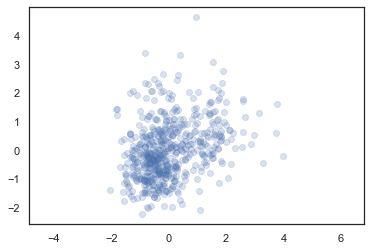

In [80]:
# ANSWER
# Plot explained_variance_

plt.scatter(Xs[:, 0], Xs[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
plt.axis('equal');


In [82]:
# ANSWER
# Apply dimensionality reduction to Xs using transform
pca = decomposition.PCA(n_components=3)
pca.fit(Xs)
X_pca = pca.transform(Xs)
print("original shape:   ", Xs.shape)
print("transformed shape:", X_pca.shape)

original shape:    (569, 30)
transformed shape: (569, 3)


In [85]:
X_pca

array([[ 9.19283683,  1.94858307, -1.12316613],
       [ 2.3878018 , -3.76817174, -0.52929271],
       [ 5.73389628, -1.0751738 , -0.55174759],
       ...,
       [ 1.25617928, -1.90229671,  0.56273051],
       [10.37479406,  1.6720101 , -1.87702934],
       [-5.4752433 , -0.67063679,  1.49044311]])

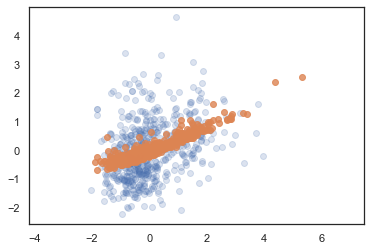

In [88]:
# ANSWER
# Create PairPlot of PCA
X_new = pca.inverse_transform(X_pca)
plt.scatter(Xs[:, 0], Xs[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

### 7. Split Data to 80/20 and Use PCA you gon in 6 as X

Split data 80/20 and Use KNN to find score.

In [106]:
# ANSWER
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

pca = decomposition.PCA(n_components=6)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

print("original shape:   ", X_train.shape)
print("transformed shape:", X_train_pca.shape)

original shape:    (455, 30)
transformed shape: (455, 6)


In [111]:
# ANSWER
pca.fit(X_train_pca, y_train)
pca.score(X_test_pca, y_test)

-11.781680892255165

**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)

[Breast Cancer Machine Learning Prediction](https://gtraskas.github.io/post/breast_cancer/)

[Understanding PCA (Principal Component Analysis) with Python](https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21)



---



---



> > > > > > > > > © 2019 Institute of Data


---



---



